In [4]:
import pandas as pd, numpy as np
import matplotlib, seaborn as sns
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,3.5)
plt.rcParams['figure.constrained_layout.use'] = True

In [3]:
# load data
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc_series = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)

C:\Users\joche\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


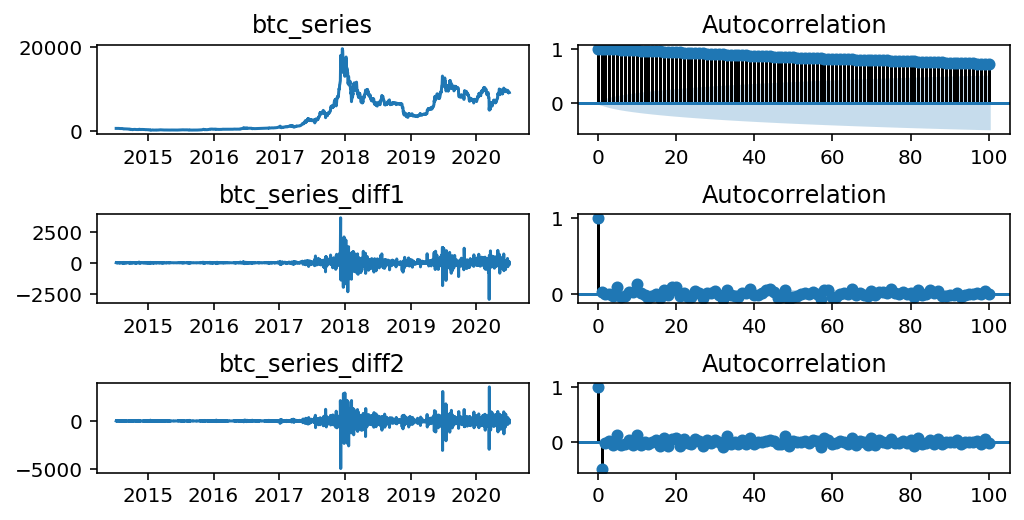

In [5]:
# raw series differencing and acf overview
from statsmodels.graphics.tsaplots import plot_acf
#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_series); axes[0,0].set_title('btc_series')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_series.diff().dropna()); axes[1,0].set_title('btc_series_diff1')
plot_acf((btc_series.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_series.diff().diff().dropna()); axes[2,0].set_title('btc_series_diff2')
plot_acf(btc_series.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [7]:
# log series differencing and acf overview
btc_log = np.log(btc_series)

#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_log); axes[0,0].set_title('btc_series_log')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_log.diff().dropna()); axes[1,0].set_title('btc_series_log_diff1')
plot_acf((btc_log.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_log.diff().diff().dropna()); axes[2,0].set_title('btc_series_log_diff2')
plot_acf(btc_log.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [6]:
from pmdarima.arima.utils import ndiffs
print('ADF_order:\t', ndiffs(btc_series, test='adf'))
print('PP_order:\t', ndiffs(btc_series, test='pp'))
print('KPSS_order:\t', ndiffs(btc_series, test='kpss'))

ADF_order:	 1
PP_order:	 1
KPSS_order:	 1


In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_pacf(btc_series.diff().dropna(), ax=axes[1])

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_acf(btc_series.diff().dropna(), ax=axes[1])

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_pacf(btc_log.diff().dropna(), ax=axes[1])

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_acf(btc_log.diff().dropna(), ax=axes[1])

In [15]:
# manually compare different ARIMA(p,d,q) variants for lowest AIC
from statsmodels.tsa.arima_model import ARIMA
import warnings

def evaluate_arima_variants(p_values, q_values):
    min_aic, opt_order = float('inf'), None
    for p in p_values:
        for q in q_values:
            current_order = (p, 1, q)
            try:
                model = ARIMA(np.log(btc_series), order=current_order)
                model_fit = model.fit(disp=False)
                print('Current try: ARIMA{}'.format(current_order))
                if model_fit.aic < min_aic:
                    min_aic, opt_order = model_fit.aic, current_order
            except:
                continue
    opt_model = ARIMA(np.log(btc_series), order=opt_order)
    opt_fitted = opt_model.fit(disp=False)
    print('ARIMA{}\nAIC:   {}\nBIC:   {}\nHQIC:  {}'.format(opt_order, opt_fitted.aic, opt_fitted.bic, opt_fitted.hqic))
        
p_values = [0, 5, 10]
q_values = [0, 5, 10]
warnings.filterwarnings('ignore')
evaluate_arima_variants(p_values, q_values)

Current try: ARIMA(0, 1, 0)
Current try: ARIMA(0, 1, 5)
Current try: ARIMA(0, 1, 10)
Current try: ARIMA(5, 1, 0)
Current try: ARIMA(5, 1, 5)
Current try: ARIMA(5, 1, 10)
Current try: ARIMA(10, 1, 0)
Current try: ARIMA(10, 1, 5)
Current try: ARIMA(10, 1, 10)
ARIMA(0, 1, 10)
AIC:   -7962.5181209468765
BIC:   -7894.234688698755
HQIC:  -7937.559129506748


In [16]:
warnings.filterwarnings('ignore')

data = btc_series

train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

order = (10,1,10)

model = ARIMA(data, order=order)
model_fitted = model.fit(disp=False)
print('ARIMA{}\nAIC:   {}\nBIC:   {}\nHQIC:  {}\n'.format(order, model_fitted.aic, model_fitted.bic, model_fitted.hqic))
print(model_fitted.summary())


ARIMA(10, 1, 10)
AIC:   30765.839504832373
BIC:   30891.02579728726
HQIC:  30811.59765580594

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2187
Model:               ARIMA(10, 1, 10)   Log Likelihood              -15360.920
Method:                       css-mle   S.D. of innovations            271.605
Date:                Tue, 07 Jul 2020   AIC                          30765.840
Time:                        23:28:08   BIC                          30891.026
Sample:                    07-08-2014   HQIC                         30811.598
                         - 07-02-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.8731      5.957      0.650      0.516      -7.802      15.548
ar.L1.D.Close      0.6092

In [ ]:
# Auto fit ARIMA model
